# Twitter author prediction

## Prerequisites

### Importing necessary libraries

In [120]:
import random; random.seed(53)
import pandas as pd

# Import all we need from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import itertools


In [121]:
import matplotlib.pyplot as plt
import numpy as np
def plot_and_return_top_features(classifier, vectorizer, top_features=20):
    """
    Plot the top features in a binary classification model and remove possible overlap.

    Adapted from https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
    and https://stackoverflow.com/a/26980472 by @kjam
    """
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names_out()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:top_features]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-top_features:]
    top_coefficients = np.hstack([topn_class1, topn_class2])
    if set(topn_class1).union(topn_class2):
        top_coefficients = topn_class1
        for ce in topn_class2:
            if ce not in topn_class1:
                top_coefficients.append(ce)

    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in [tc[0] for tc in top_coefficients]]
    plt.bar(np.arange(len(top_coefficients)), [tc[0] for tc in top_coefficients], color=colors)
    plt.xticks(np.arange(len(top_coefficients)),
               [tc[1] for tc in top_coefficients], rotation=60, ha='right')
    plt.show()
    return top_coefficients

In [122]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figure=0):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figure)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



### Load the data

In [123]:
# Load data
tweet_df = pd.read_csv("C:/Users/Oliver/Documents/BCE/Tárgyak/9. félév/Többváltozós statisztika/tweets.csv")

Ez a másik adatbázis

In [124]:
# Vakhal
# Load data
tweet_df = pd.read_csv("C:/Users/Oliver/Documents/BCE/Tárgyak/9. félév/Többváltozós statisztika/tweets_1.csv")
#extract the texts and the authors where the author is either HillaryClinton or realDonaldTrump
tweet_df = tweet_df[tweet_df.is_retweet == False]
tweet_df = tweet_df[["handle", "text"]]
tweet_df.columns = ["author", "status"]


In [125]:
# Create target
y = tweet_df["author"]
# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(tweet_df["status"], y,  test_size=0.2, stratify=y, random_state=42)

## Data cleaning

### CountVectorizer

In [126]:
count_vectorizer = CountVectorizer(stop_words="english", min_df=0.05, max_df=0.9)
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

### Tf-Idf

In [127]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=0.05, max_df=0.9)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

## Training the models

### Training a multinomial naive Bayes model

In [128]:
# Create and fit the model for the tf-idf data
param_grid_nb = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
    'fit_prior': [True, False],
}
tf_idf_nb_cv = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5)
tf_idf_nb_cv.fit(tfidf_train, y_train)
tf_idf_nb = tf_idf_nb_cv.best_estimator_
tf_idf_nb_pred = tf_idf_nb.predict(tfidf_test)
print("Best parameters: {}".format(tf_idf_nb_cv.best_params_))

# Create and fit the model for the count data

count_nb = MultinomialNB()

count_nb.fit(count_train, y_train)
count_nb_pred = count_nb.predict(count_test)

Best parameters: {'alpha': 0.0001, 'fit_prior': True}


### Training an SVM model

In [129]:
param_grid_svc = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "dual": [True, False],
}
tf_idf_svc_cv = GridSearchCV(LinearSVC(), param_grid=param_grid_svc, cv=5)
tf_idf_svc_cv.fit(tfidf_train, y_train)
tf_idf_svc_pred = tf_idf_svc_cv.predict(tfidf_test)
tf_idf_svc = tf_idf_svc_cv.best_estimator_
print("Best parameters: {}".format(tf_idf_svc_cv.best_params_))

Best parameters: {'C': 0.1, 'dual': True}


### Training a logistic regression model

In [130]:
param_grid_lr = {
    "C": [0.0001, 0.001, 0.01, 0.1, 1, 10]
}
tf_idf_lr_cv = GridSearchCV(LogisticRegression(), param_grid=param_grid_lr, cv=5)
tf_idf_lr_cv.fit(tfidf_train, y_train)
tf_idf_lr = tf_idf_lr_cv.best_estimator_
tf_idf_lr_pred = tf_idf_lr.predict(tfidf_test)
print("Best parameters: {}".format(tf_idf_lr_cv.best_params_))

Best parameters: {'C': 1}


### Training a decision tree model

In [131]:
param_grid_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 8],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6, 7, 8]
}
tf_idf_dt_cv = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid_dt, cv=5)
tf_idf_dt_cv.fit(tfidf_train, y_train)
tf_idf_dt = tf_idf_dt_cv.best_estimator_
tf_idf_dt_pred = tf_idf_dt.predict(tfidf_test)
print("Best parameters: {}".format(tf_idf_dt_cv.best_params_))

Best parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1}


### Training a random forest model

In [132]:
tf_idf_rf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100, max_samples=0.8, max_features=0.8, random_state=42, n_jobs=-1)
tf_idf_rf.fit(tfidf_train, y_train)
tf_idf_rf_pred = tf_idf_rf.predict(tfidf_test)

## Accuracy scores (for the tf-idf vectorizer)

In [133]:
target_values = list(tf_idf_lr.classes_)
target_values

['HillaryClinton', 'realDonaldTrump']

### Confusion matrices

In [134]:
tf_idf_nb_cm = metrics.confusion_matrix(y_test, tf_idf_nb_pred, labels=target_values, normalize='true')
tf_idf_svc_cm = metrics.confusion_matrix(y_test, tf_idf_svc_pred, labels=target_values, normalize='true')
tf_idf_lr_cm = metrics.confusion_matrix(y_test, tf_idf_lr_pred, labels=target_values, normalize='true')
tf_idf_dt_cm = metrics.confusion_matrix(y_test, tf_idf_dt_pred, labels=target_values, normalize='true')
tf_idf_rf_cm = metrics.confusion_matrix(y_test, tf_idf_rf_pred, labels=target_values, normalize='true')

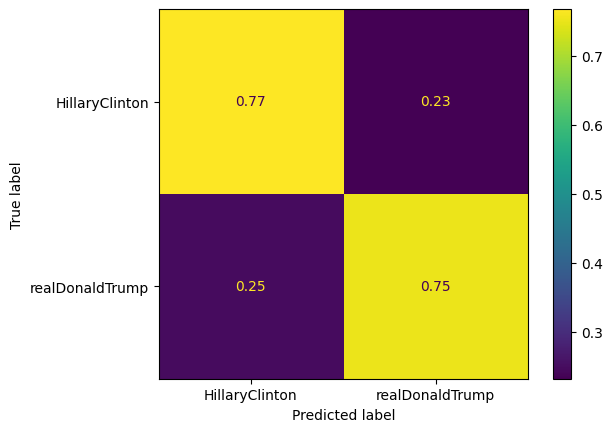

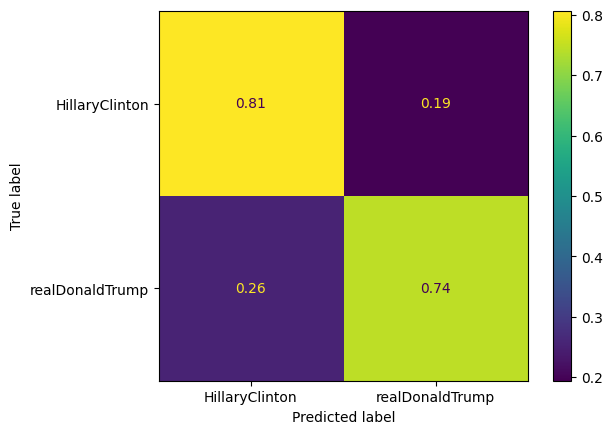

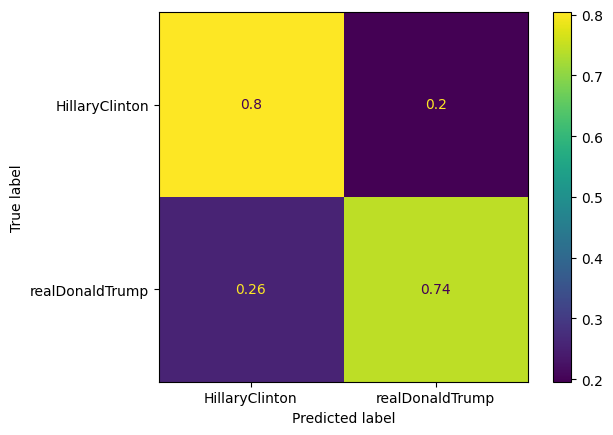

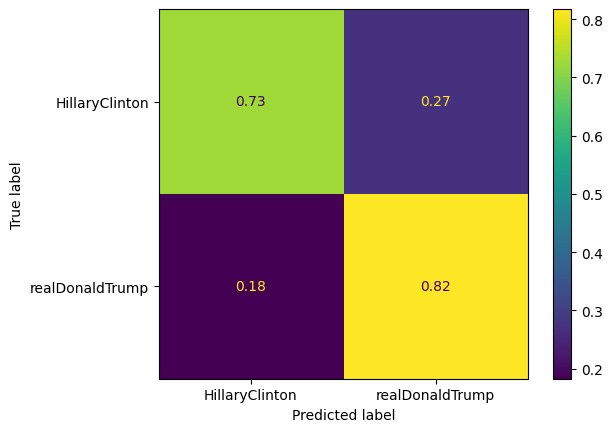

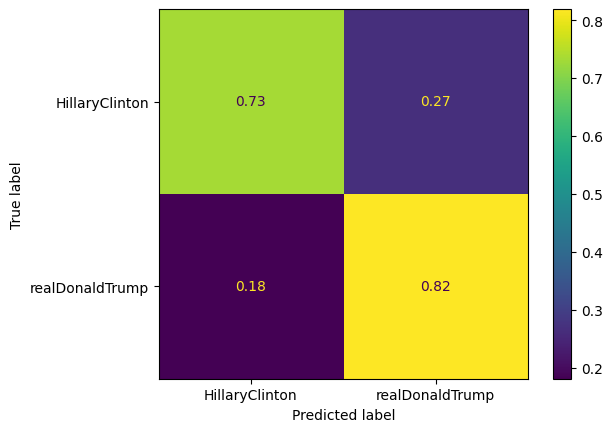

In [135]:
metrics.ConfusionMatrixDisplay(tf_idf_nb_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_svc_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_lr_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_dt_cm, display_labels=target_values).plot()
metrics.ConfusionMatrixDisplay(tf_idf_rf_cm, display_labels=target_values).plot()

### Accuracy scores of the models (on the test set)

In [136]:
print("Naive Bayes\t\t", tf_idf_nb.score(tfidf_test, y_test))
print("SVC\t\t\t", tf_idf_svc.score(tfidf_test, y_test))
print("Logistic Regression\t", tf_idf_lr.score(tfidf_test, y_test))
print("Decision Tree\t\t", tf_idf_dt.score(tfidf_test, y_test))
print("Random Forest\t\t", tf_idf_rf.score(tfidf_test, y_test))

Naive Bayes		 0.759825327510917
SVC			 0.7729257641921398
Logistic Regression	 0.77117903930131
Decision Tree		 0.7755458515283843
Random Forest		 0.7799126637554585


### Cross-validation (on the training set)

In [137]:
print(f"Naive Bayes:\t\t{tf_idf_nb_cv.best_score_}")
print(f"SVC:\t\t\t{tf_idf_svc_cv.best_score_}")
print(f"Logistic Regression:\t{tf_idf_lr_cv.best_score_}")
print(f"Decision Tree:\t\t{tf_idf_dt_cv.best_score_}")
print(f"Random Forest:\t\tNo cross validation performed") # BaggingClassifier does not support cross validation

Naive Bayes:		0.756175102011597
SVC:			0.7657854296418259
Logistic Regression:	0.7666597465817168
Decision Tree:		0.7747478941465626
Random Forest:		No cross validation performed


### Recall scores of the models

In [138]:
print("Naive Bayes".ljust(20), metrics.recall_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC".ljust(20), metrics.recall_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression".ljust(20), metrics.recall_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree".ljust(20), metrics.recall_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest".ljust(20), metrics.recall_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes          0.7680608365019012
SVC                  0.8060836501901141
Logistic Regression  0.8041825095057035
Decision Tree        0.7262357414448669
Random Forest        0.7338403041825095


### Precision scores of the models

In [139]:
print("Naive Bayes".ljust(20), metrics.precision_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC".ljust(20), metrics.precision_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression".ljust(20), metrics.precision_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree".ljust(20), metrics.precision_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest".ljust(20), metrics.precision_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes          0.725314183123878
SVC                  0.7285223367697594
Logistic Regression  0.7268041237113402
Decision Tree        0.7717171717171717
Random Forest        0.7751004016064257


### f1-scores of the models

In [140]:
print("Naive Bayes".ljust(20), metrics.f1_score(y_test, tf_idf_nb_pred, labels=target_values, pos_label=target_values[0]))
print("SVC".ljust(20), metrics.f1_score(y_test, tf_idf_svc_pred, labels=target_values, pos_label=target_values[0]))
print("Logistic Regression".ljust(20), metrics.f1_score(y_test, tf_idf_lr_pred, labels=target_values, pos_label=target_values[0]))
print("Decision Tree".ljust(20), metrics.f1_score(y_test, tf_idf_dt_pred, labels=target_values, pos_label=target_values[0]))
print("Random Forest".ljust(20), metrics.f1_score(y_test, tf_idf_rf_pred, labels=target_values, pos_label=target_values[0]))

Naive Bayes          0.7460757156048015
SVC                  0.7653429602888087
Logistic Regression  0.7635379061371842
Decision Tree        0.7482859941234085
Random Forest        0.7539062499999999


### Classification reports

In [146]:
# classification report
report_nb = metrics.classification_report(y_test, tf_idf_nb_pred, labels=target_values, output_dict=True)
report_svm = metrics.classification_report(y_test, tf_idf_svc_pred, labels=target_values, output_dict=True)
report_lr = metrics.classification_report(y_test, tf_idf_lr_pred, labels=target_values, output_dict=True)
report_dt = metrics.classification_report(y_test, tf_idf_dt_pred, labels=target_values, output_dict=True)
report_rf = metrics.classification_report(y_test, tf_idf_rf_pred, labels=target_values, output_dict=True)


df_nb = pd.DataFrame.from_dict(report_nb).transpose()
df_svm = pd.DataFrame.from_dict(report_svm).transpose()
df_lr = pd.DataFrame.from_dict(report_lr).transpose()
df_dt = pd.DataFrame.from_dict(report_dt).transpose()
df_rf = pd.DataFrame.from_dict(report_rf).transpose()

report_dict = {
    "Naive Bayes": df_nb,
    "SVM": df_svm,
    "Logistic Regression": df_lr,
    "Decision Tree": df_dt,
    "Random Forest": df_rf
}

for model, report in report_dict.items():
    print(model)
    print(report)
    print("\n")

Naive Bayes
                 precision    recall  f1-score      support
HillaryClinton    0.725314  0.768061  0.746076   526.000000
realDonaldTrump   0.792517  0.752827  0.772162   619.000000
accuracy          0.759825  0.759825  0.759825     0.759825
macro avg         0.758916  0.760444  0.759119  1145.000000
weighted avg      0.761645  0.759825  0.760178  1145.000000


SVM
                 precision    recall  f1-score      support
HillaryClinton    0.728522  0.806084  0.765343   526.000000
realDonaldTrump   0.818828  0.744750  0.780034   619.000000
accuracy          0.772926  0.772926  0.772926     0.772926
macro avg         0.773675  0.775417  0.772688  1145.000000
weighted avg      0.777342  0.772926  0.773285  1145.000000


Logistic Regression
                 precision    recall  f1-score      support
HillaryClinton    0.726804  0.804183  0.763538   526.000000
realDonaldTrump   0.817052  0.743134  0.778342   619.000000
accuracy          0.771179  0.771179  0.771179     0.771179


### Roc-auc scores of the models

In [142]:
print("Naive Bayes".ljust(20), metrics.roc_auc_score(y_test, tf_idf_nb.predict_proba(tfidf_test)[:,1]))
print("SVC does not support predict_proba")
print("Logistic Regression".ljust(20), metrics.roc_auc_score(y_test, tf_idf_lr.predict_proba(tfidf_test)[:,1]))
print("Decision Tree".ljust(20), metrics.roc_auc_score(y_test, tf_idf_dt.predict_proba(tfidf_test)[:,1]))
print("Random Forest".ljust(20), metrics.roc_auc_score(y_test, tf_idf_rf.predict_proba(tfidf_test)[:,1]))

Naive Bayes          0.816599814492896
SVC does not support predict_proba
Logistic Regression  0.8401137613100979
Decision Tree        0.8283736801046702
Random Forest        0.8540052949378675
